<a href="https://colab.research.google.com/github/alexc957/Tensorflow-2-Practice/blob/Practice/Cats_Vs_Dogs_with_Data_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import the necesary libraries 

In [1]:
import os
import zipfile
import random
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

#### download the data and extract it in directory 

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2020-10-21 23:09:18--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.196.32.25, 2600:1408:5400:290::e59, 2600:1408:5400:293::e59
Connecting to download.microsoft.com (download.microsoft.com)|23.196.32.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M   117MB/s    in 6.7s    

2020-10-21 23:09:25 (118 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

12501
12501


#### Create the directories for train and testing 

In [4]:
try:
    os.mkdir('/tmp/cats-v-dogs/')
    os.mkdir('/tmp/cats-v-dogs/training')
    os.mkdir('/tmp/cats-v-dogs/testing')
    os.mkdir('/tmp/cats-v-dogs/training/cats/')
    os.mkdir('/tmp/cats-v-dogs/testing/cats/')
    os.mkdir('/tmp/cats-v-dogs/training/dogs/')
    os.mkdir('/tmp/cats-v-dogs/testing/dogs/')
except OSError:
    pass

create a function to split the data and save it in a given directory

In [5]:
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):

    all_fnames = os.listdir(SOURCE)
    all_fnames = random.sample(all_fnames, len(all_fnames))
    split_index = round(len(all_fnames)*SPLIT_SIZE)
    training_set = all_fnames[:split_index]
    test_set = all_fnames[split_index:]
    for training_image in training_set:
        image_path = os.path.join(SOURCE,training_image)
        if os.path.getsize(image_path)>0:
            copyfile(image_path,os.path.join(TRAINING,training_image))
    
    for test_image in test_set:
        image_path = os.path.join(SOURCE,test_image)
        if os.path.getsize(image_path)>0:
            copyfile(image_path,os.path.join(TESTING,test_image))



CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

11250
11251
1250
1249


#### Create the model and compile it

In [7]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(2,2), input_shape=(150,150,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(64,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(128,(2,2),activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
                              
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

#### Create the train and validation generator

In [8]:
TRAINING_DIR = "/tmp/cats-v-dogs/training/"
train_datagen =  ImageDataGenerator(
    rescale=1./255.,
    rotation_range = 60,
    width_shift_range=0.25,
    height_shift_range=0.25,
    shear_range=0.2,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest',

)


# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(
     TRAINING_DIR,
     batch_size = 32,
    class_mode ='binary',
    target_size = (150,150)
)

VALIDATION_DIR = "/tmp/cats-v-dogs/testing/"
validation_datagen = ImageDataGenerator(rescale=1./255.)


# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(
     VALIDATION_DIR,
     batch_size = 32,
    class_mode ='binary',
    target_size = (150,150)
)


Found 22500 images belonging to 2 classes.
Found 2498 images belonging to 2 classes.


#### Train the model


In [9]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
199/704 [=======>......................] - ETA: 1:50 - loss: 0.6895 - acc: 0.5589

/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 32 bytes but only got 0. Skipping tag 270
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 5 bytes but only got 0. Skipping tag 271
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 272
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 282
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only

704/704 [==============================] - 162s 230ms/step - loss: 0.6396 - acc: 0.6283 - val_loss: 0.5494 - val_acc: 0.7274
Epoch 2/30
704/704 [==============================] - 161s 228ms/step - loss: 0.5778 - acc: 0.6948 - val_loss: 0.5804 - val_acc: 0.7058
Epoch 3/30
704/704 [==============================] - 161s 229ms/step - loss: 0.5421 - acc: 0.7241 - val_loss: 0.6304 - val_acc: 0.6942
Epoch 4/30
704/704 [==============================] - 161s 228ms/step - loss: 0.5290 - acc: 0.7380 - val_loss: 0.4150 - val_acc: 0.8010
Epoch 5/30
704/704 [==============================] - 160s 228ms/step - loss: 0.5054 - acc: 0.7533 - val_loss: 0.4030 - val_acc: 0.8159
Epoch 6/30
704/704 [==============================] - 160s 227ms/step - loss: 0.4917 - acc: 0.7625 - val_loss: 0.3931 - val_acc: 0.8171
Epoch 7/30
704/704 [==============================] - 161s 228ms/step - loss: 0.4825 - acc: 0.7704 - val_loss: 0.3928 - val_acc: 0.8243
Epoch 8/30
704/704 [==============================] - 160s 

#### # PLOT LOSS AND ACCURACY

Text(0.5, 1.0, 'Training and validation loss')

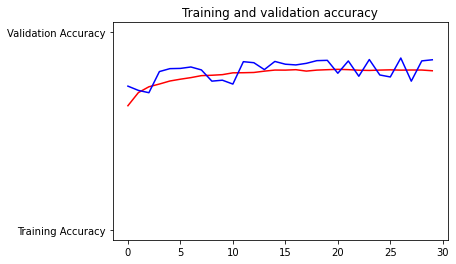

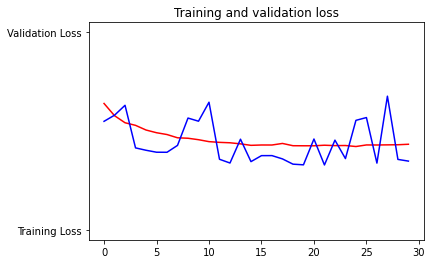

In [10]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")


plt.title('Training and validation loss')

In [13]:
model.save('modelv1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: modelv1/assets


In [14]:
from google.colab import files
files.download('modelv1') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>